# Подготовка к обработке данных

## Подключение и преднастройка необходимых компонент

Подключение Google Drive

In [1]:
%%time
# монтируем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.25 s, sys: 211 ms, total: 1.46 s
Wall time: 24.8 s


Подключение глобально необходимых библиотек

In [51]:
!pip install catboost
!pip install imbalanced-learn

In [52]:
# для отрисовки графиков
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
import polars as pl

from imblearn.over_sampling import SMOTE

# для объединения в одну модель
from sklearn.pipeline import Pipeline

# для масштабирования
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# модули оценщика
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# для вывода результатов
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

Инициализация константы для random_state

In [3]:
# для повторяемости результатов
SEED = 24

Настройка графиков

In [4]:
# преднастройка графиков
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

# чтобы графики были в одном окне
%matplotlib inline

## Загрузка датасета

Чтение датасета, чтобы к нему можно было обратиться методами sklearn

In [6]:
# загружаем данные с Google Drive
df = pd.read_csv('/content/drive/MyDrive/6_Sem/DPL/Dataset/liver_cirrhosis.csv')

Проверка типов данных столбцов и того, как их интерпретировал pandas

In [7]:
# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

## Анализ датасета

### Проверка статистики

Проверка на наличие отклонений важных характеристик числовых признаков: среднего арифметического, стандартного квадратичного отклонения, перцентилей, а также максимума и минимума

In [12]:
# выводим статистику числовых записей датасета
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,1887.117040,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


Уточнение показателей для категориальных данных

In [13]:
# выводим статистику категориальных записей датасета
df.describe(include = [object, 'bool'])

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,25000,25000,25000,25000,25000,25000,25000
unique,3,2,2,2,2,2,3
top,C,Placebo,F,N,N,N,N
freq,13516,15827,22137,16798,15243,13614,20220


Оценка категориальных признаков на наличие артефактов

In [14]:
# итерируемся по столбцам датасета
for name, values in df.items():
  if values.dtype != np.float64:
    print(f"{name}: {df[name].unique()}")

N_Days: [2221 1230 4184 2090 2105 4427 1418   51 2504 1012 1149 1037 1234  334
  733 1581 1443 3823 3170 1735 1558 1067 1666  191 1874 1690  460 2176
 3839  727 1092  943 1347 1368 1170 2286 2050 2224 2022 3992 1434 2338
 2995  694  264 2503 1168 2365 3707 2475 2540  681 2171 1455 1769 3445
 1077 2267 2081 1908  799 2111 1419 2255 2576 2202  617 3099 1568 1525
  839 3030 4509 2609 2442 3492 2195  976 2855 1504  348 1301  989 2644
 2797 1702 1320 2834 1103  489 1899 1945 1297  994  352 2527  549  939
 2698 1342 1831  625 3021   77  611 2635 3086 1191 1462 1783 3527 2721
 1725 1343 2103 3820 1785 1656  597 1375 1560 3913 3850 4556 2583 2556
 3255  859  837  974 2071 2332 1119 1615  559  326  193 1349  904 1293
  533  708 2272  691 3584 2990 2976  130 3282 2288 1653 1481  737 1150
 1616 1433  877 2555  732 2297 2468 1536  703 2844  797 1978 1129 2580
 1141 1072 1095 1639 1882 4523 2944 4467 2563 1356 1236 1223 2386 2598
 2769 1786  304 4039 1592  980 2863 4062 2713  853 2452 3336 4795 266

Графики распределения признаков

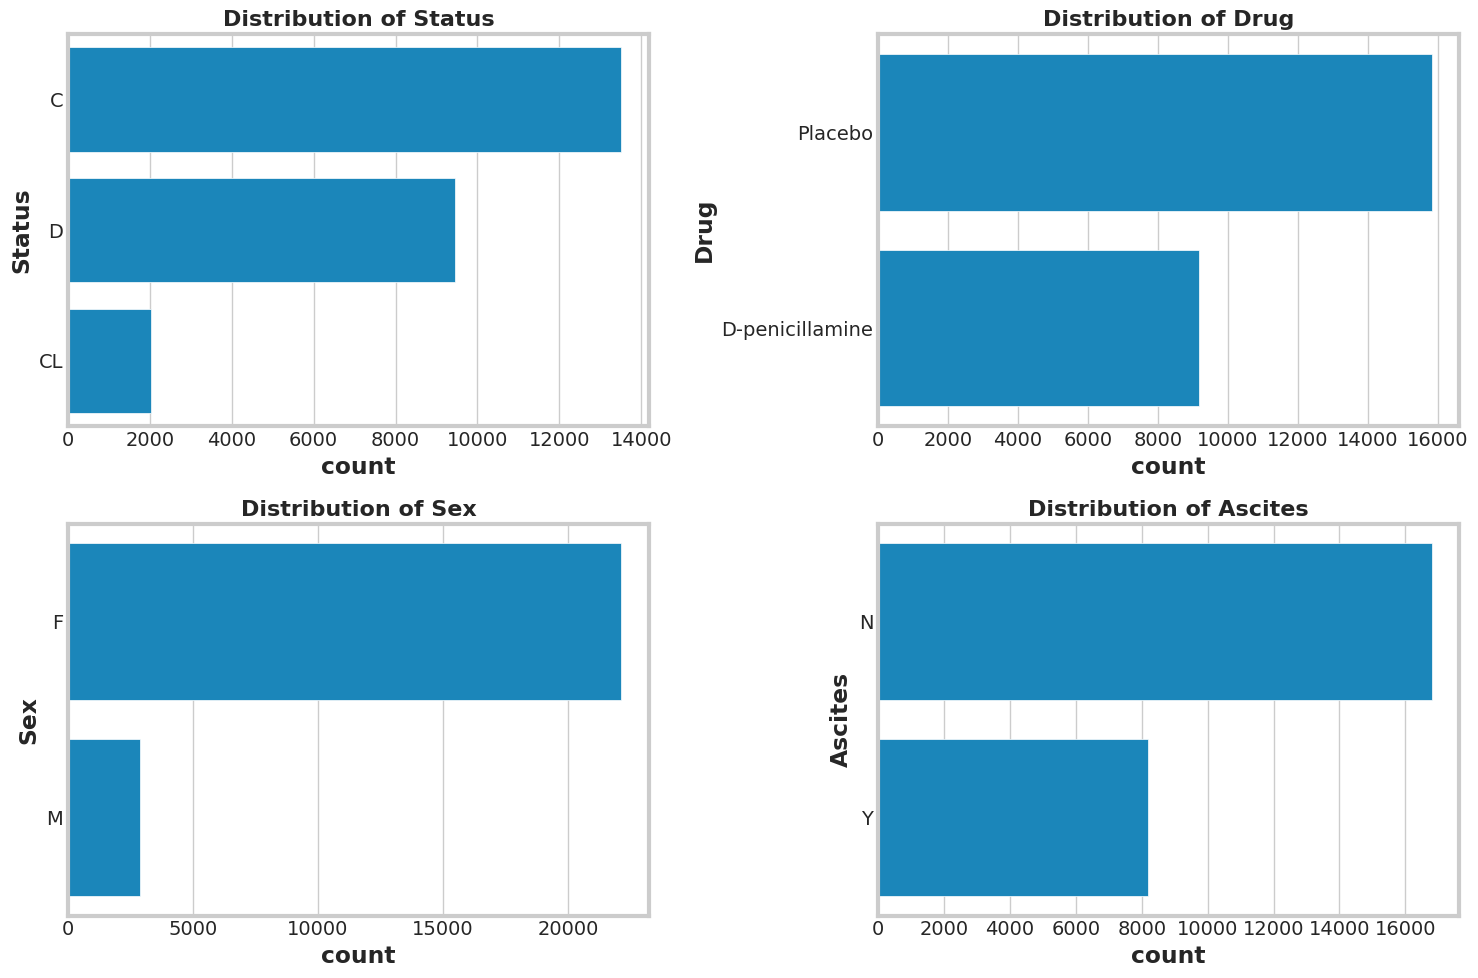

In [19]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for 'Status'
sns.countplot(y='Status', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Status', fontweight='bold', fontsize=16)
axes[0, 0].set_xlabel(axes[0, 0].get_xlabel(), fontweight='bold')
axes[0, 0].set_ylabel(axes[0, 0].get_ylabel(), fontweight='bold')

# Plot for 'Drug'
sns.countplot(y='Drug', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Drug', fontweight='bold', fontsize=16)
axes[0, 1].set_xlabel(axes[0, 1].get_xlabel(), fontweight='bold')
axes[0, 1].set_ylabel(axes[0, 1].get_ylabel(), fontweight='bold')

# Plot for 'Sex'
sns.countplot(y='Sex', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Sex', fontweight='bold', fontsize=16)
axes[1, 0].set_xlabel(axes[1, 0].get_xlabel(), fontweight='bold')
axes[1, 0].set_ylabel(axes[1, 0].get_ylabel(), fontweight='bold')

# Plot for 'Ascites'
sns.countplot(y='Ascites', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Ascites', fontweight='bold', fontsize=16)
axes[1, 1].set_xlabel(axes[1, 1].get_xlabel(), fontweight='bold')
axes[1, 1].set_ylabel(axes[1, 1].get_ylabel(), fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Статистика

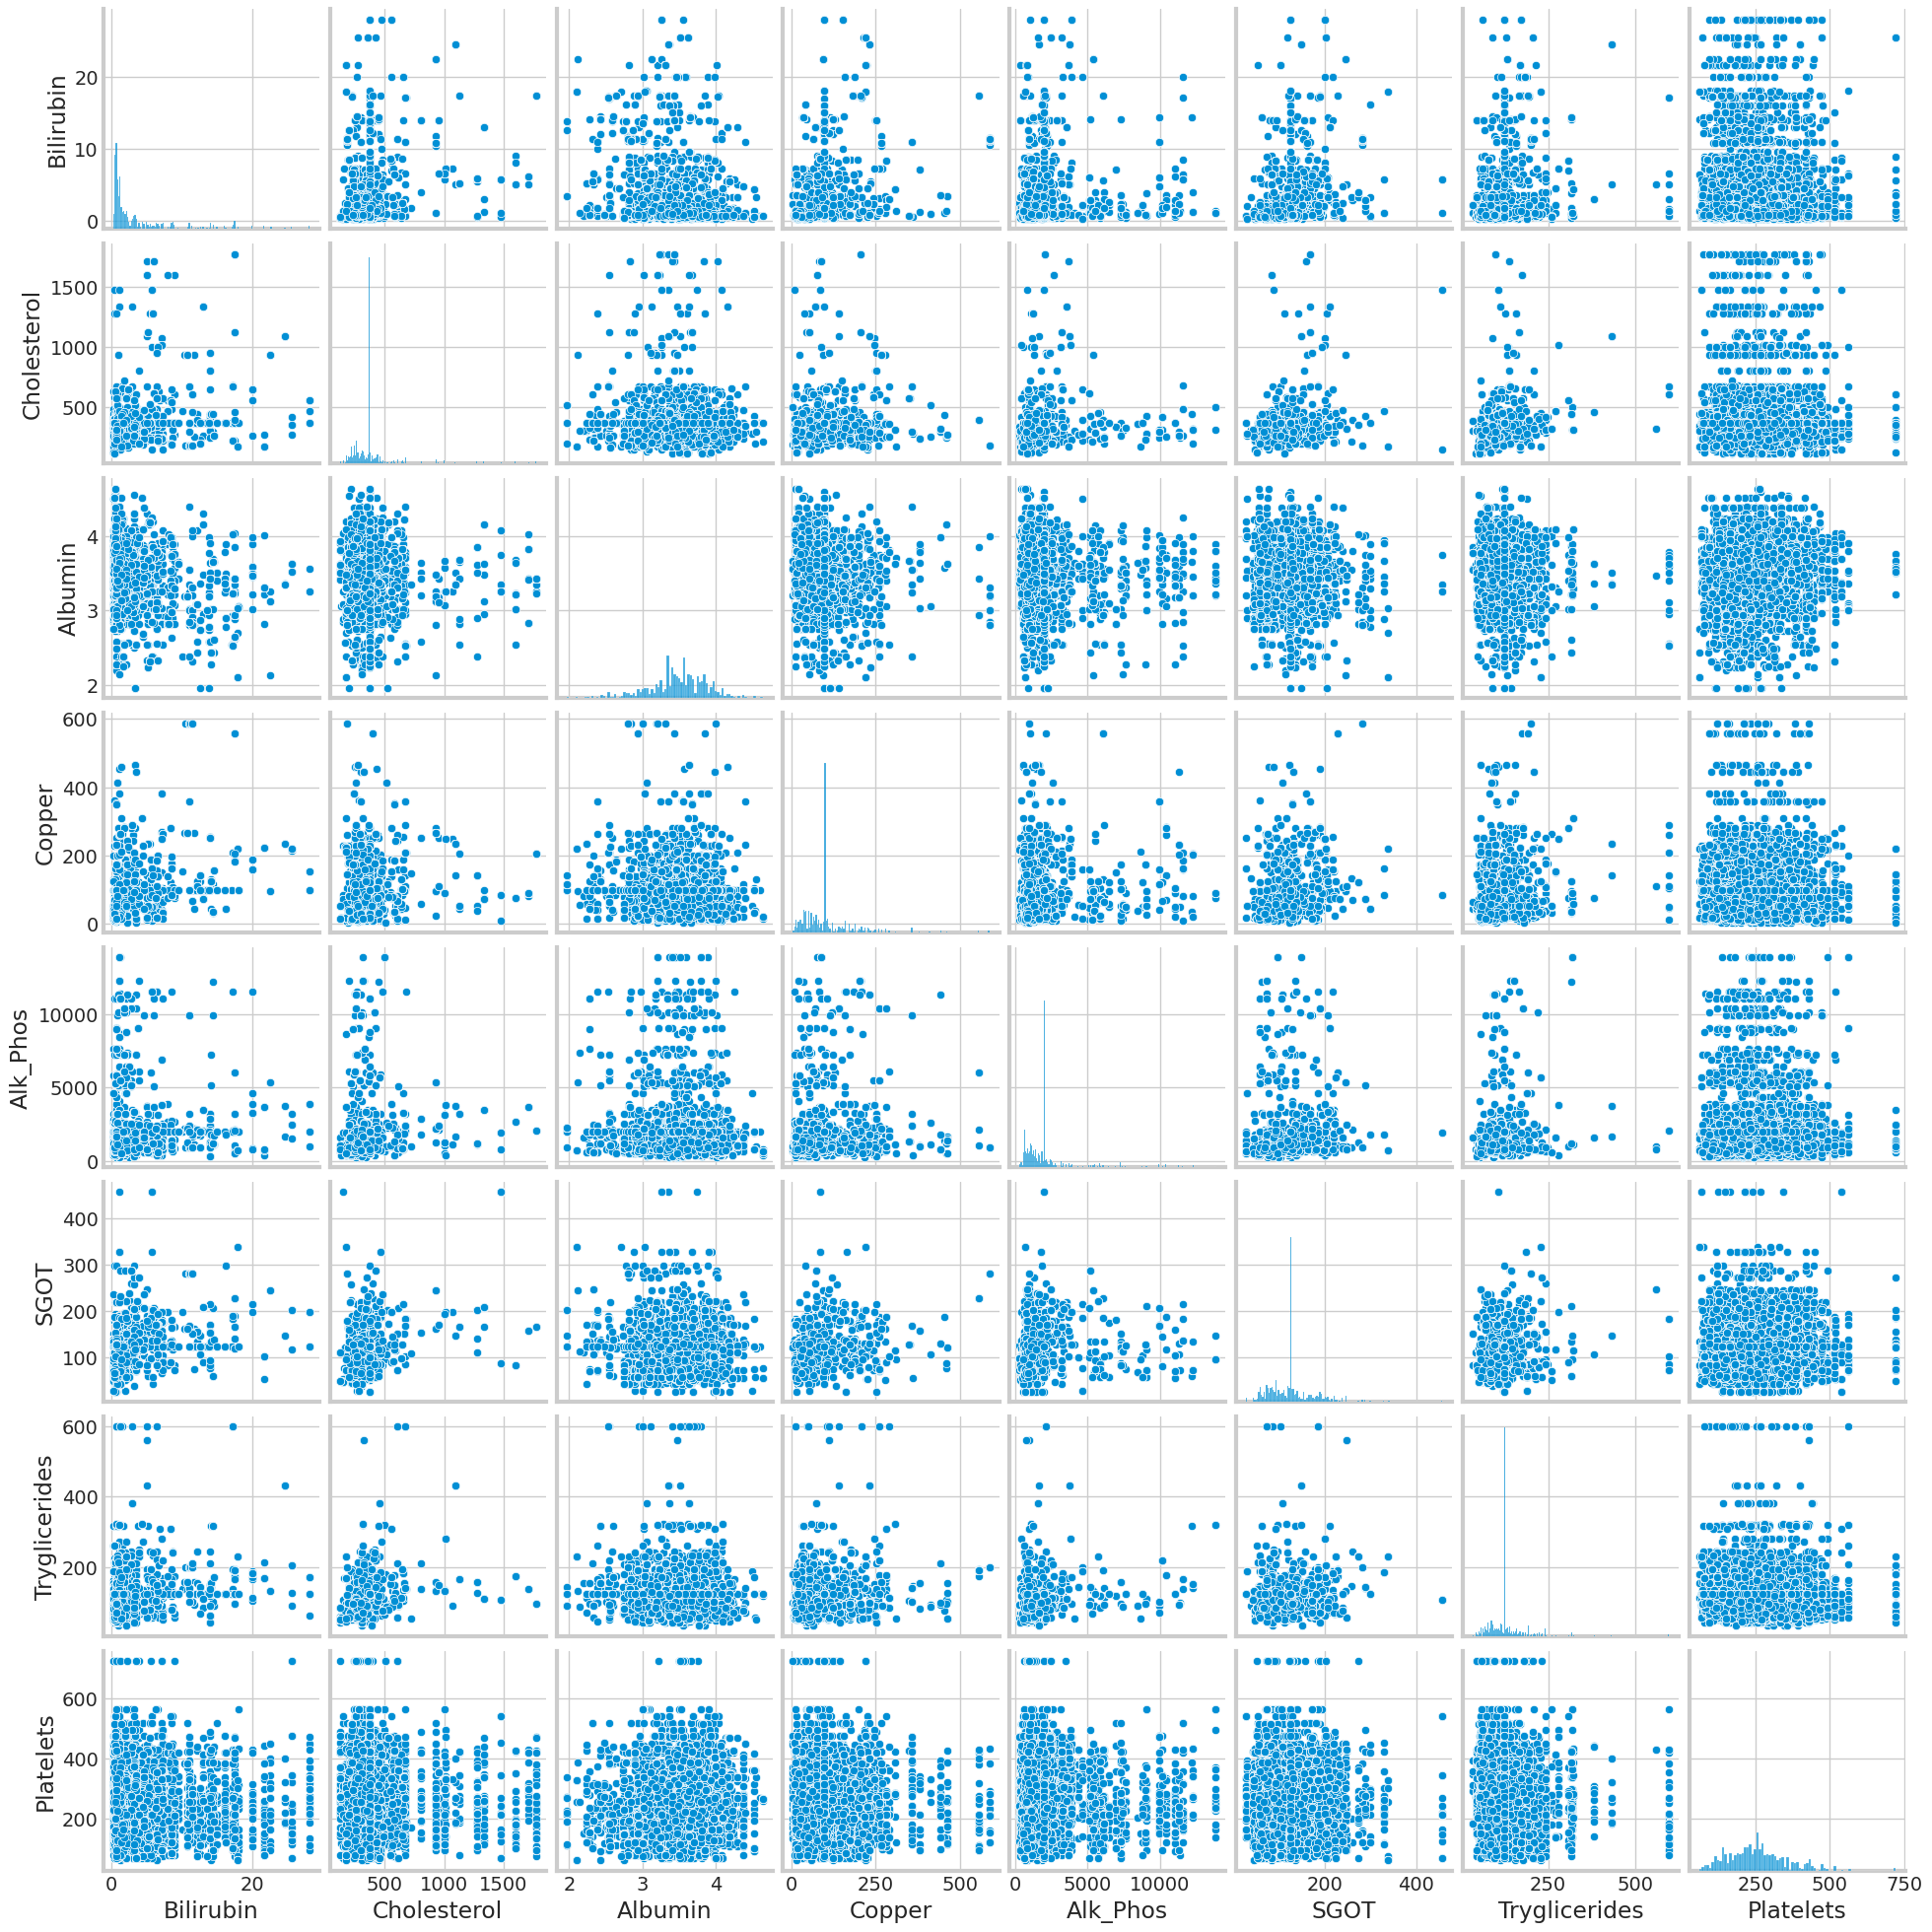

In [20]:
sns.pairplot(df[['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets']])
plt.show()

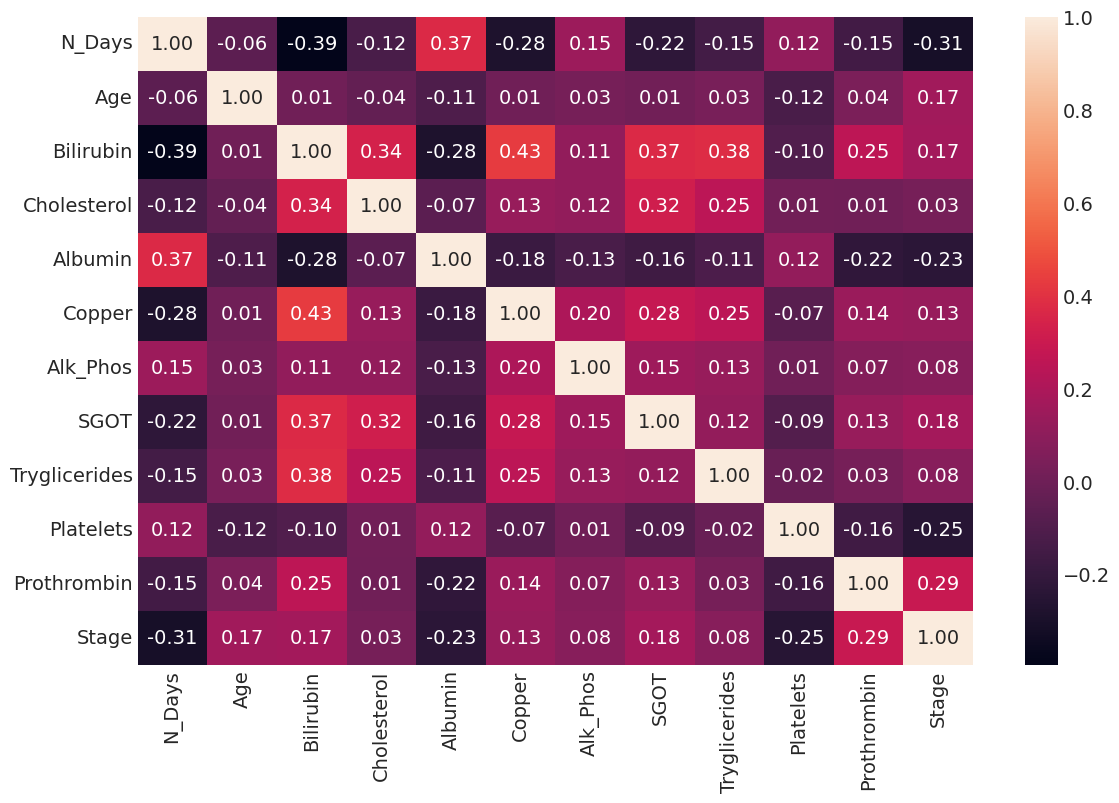

In [21]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

### Обобщение датасета

Создание обобщенного датасета

In [106]:
# новый датасет для проверки корелляции
grouped_df = df

grouped_df = grouped_df.dropna()

# выводим получившуюся структуру
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

Прямое преобразование категориальных признаков в числовые

In [107]:
grouped_df = pd.get_dummies(grouped_df, columns=['Status', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], drop_first = True)
grouped_df

,N_Days,Drug,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Prothrombin,Stage,Status_CL,Status_D,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,2221,Placebo,18499,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,...,9.9,1,False,False,False,False,True,False,False,False
1,1230,Placebo,19724,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,...,10.8,2,False,False,True,True,False,True,False,False
2,4184,Placebo,11839,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,...,10.0,2,False,False,False,False,False,False,False,False
3,2090,Placebo,16467,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,...,10.2,2,False,True,False,False,False,False,False,False
4,2105,Placebo,21699,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,...,11.5,1,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D-penicillamine,23612,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,...,11.0,2,False,True,False,False,False,False,False,False
24996,3584,D-penicillamine,23612,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,...,11.0,2,False,True,False,False,False,False,False,False
24997,971,D-penicillamine,16736,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,...,13.0,3,False,True,False,False,True,True,False,True
24998,3707,D-penicillamine,16990,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,...,10.9,2,False,False,False,False,True,False,False,False


## Подготовка данных

### Заполнение отсутствующих значений

Проверка на наличие пропусков

In [43]:
# отдельно считаем количество пустых записей в столбцах
skips_num = grouped_df.isna().sum()

print(f"Пропуски по столбцам:\n{skips_num}\n")

# выводим сумму по столбцам
print(f"Всего пропусков: {skips_num.sum()}")

Пропуски по столбцам:
N_Days            0
Age               0
Sex               0
Bilirubin         0
Cholesterol       0
Albumin           0
Copper            0
Alk_Phos          0
SGOT              0
Tryglicerides     0
Platelets         0
Prothrombin       0
Stage             0
Status_CL         0
Status_D          0
Drug_Placebo      0
Ascites_Y         0
Hepatomegaly_Y    0
Spiders_Y         0
Edema_S           0
Edema_Y           0
dtype: int64

Всего пропусков: 0


### Выбор обучающего и тестового наборов

Разделение данных на те, по которым предсказываем, и на те, которые предсказываем

In [108]:
grouped_df = grouped_df.sample(n=10000)

In [109]:
grouped_df['Drug'] = grouped_df['Drug'].map({'Placebo': 0, 'D-penicillamine': 1})

# выбираем целевой признак
y_df = grouped_df['Drug']

# выбираем остальные признаки
X_df = grouped_df.drop(['Drug'], axis=1)

# выводим на всякий случай
y_df

5622     0
10451    0
4812     1
7558     0
8187     1
        ..
11441    0
18624    1
1419     0
16904    0
4977     1
Name: Drug, Length: 10000, dtype: int64

Выделяем обучающую и тестовую выборки

In [110]:
# разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size = 0.2, random_state=SEED)

In [111]:
# Балансировка данных с использованием SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Масштабирование признаков

Выбираем тип масштабирования

In [112]:
# выбираем тип scaler'а
scaler = StandardScaler()

# скалируем
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# проверяем
X_train_balanced

array([[-0.29263997, -0.62978301, -0.25681828, ...,  1.19265591,
        -0.43382773, -0.21884495],
       [-0.77333571, -0.15495791,  1.2253558 , ..., -0.8384648 ,
         2.30506241, -0.21884495],
       [ 0.23658314, -1.53439986, -0.61613321, ..., -0.8384648 ,
        -0.43382773, -0.21884495],
       ...,
       [ 0.34279401, -0.99505334, -0.32418983, ..., -0.8384648 ,
        -0.43382773, -0.21884495],
       [ 0.06078584, -0.15811815, -0.42522804, ..., -0.8384648 ,
        -0.43382773, -0.21884495],
       [ 0.50760397,  0.49051979,  0.16247361, ..., -0.8384648 ,
        -0.43382773, -0.21884495]])

# **ЛР1**

## Описание

Задание 1. Найти набор данных (датасет) для классификации удовлетворяющий следующим условиям: более 10 000 строк, более 20 столбцов, разные типы в столбцах, обязательно наличие целевого признака (таргета).
<br>
Задание 2 . Провести классификацию найденного датасета, методом к- ближайших соседей. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.


## Решение

### Выбор датасета

На основании приведенных в описании 1 лаборатоной работы критериев, был выбран датасет по классификации стадий цирроза печени. Целью работы является выявление какой препарат принимал больной на основании заранее заданных параметров. Целевой показатель при этом может принимать 2 значения: 1 (Placebo) или 0 (D-penicillamine). Ссылка на используемый датасет приведена далее: https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification/data

### Подключение модулей

In [113]:
# стандартный модуль KNN
from sklearn.neighbors import KNeighborsClassifier

### **sklearn.neighbors.KNeighborsClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [114]:
%%time
# Сокращение диапазонов параметров
k_range = [3, 5, 7, 9, 11]
algorithms = ['ball_tree', 'kd_tree']
class_weights = ['balanced', None]
metrics = ['euclidean', 'manhattan']

parameters = {
    'n_neighbors': k_range,
    'algorithm': algorithms,
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40],
    'metric': metrics
}

# Используем RandomizedSearchCV вместо GridSearchCV
grid_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring='f1_weighted',
    n_iter=50,  # количество комбинаций параметров для проверки
    n_jobs=-1,  # использовать все доступные процессоры
    cv=5,  # количество фолдов в кросс-валидации
    random_state=42
)

# обучаем модель
grid_knn.fit(X_train_balanced, y_train_balanced)

CPU times: user 2.15 s, sys: 365 ms, total: 2.51 s
Wall time: 2min 51s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'leaf_size': [10, 20, 30, 40],
                                        'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='f1_weighted')

Вывод результата кросс-валидации

In [115]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_knn.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_knn.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_knn_pred = grid_knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_knn_pred)}\n')

Лучшие параметры:
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'kd_tree'}

Показатель f1 для лучшей модели составил: 91.89%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1303
           1       0.85      0.87      0.86       697

    accuracy                           0.90      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.90      0.90      0.90      2000


Матрица ошибок: 
[[1197  106]
 [  88  609]]



# **ЛР2**

## Описание

Задание 1 . Провести классификацию найденного датасета, методом машины опорных векторов. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Метод машины опорных векторов

In [118]:
# общий модуль для бинарной и многоклассовой классификации
from sklearn.svm import SVC

# специализированный модуль для классификации с линейным ядром
from sklearn.svm import LinearSVC

### **sklearn.svm.SVC**

---

#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [120]:
%%time

# задаем гиперпараметры
parameters = {
    'C': [0.1, 1], # коэффициент регуляризации
    'kernel': ['poly'], # тип ядра
    'degree': [3, 4], # степень для 'poly' ядра
    'gamma': ['scale', 'auto'], # коэффициент ядра для 'rbf', 'poly' и 'sigmoid'
    'coef0': [0.0, 0.5, 1.0], # смещение для 'poly' и 'sigmoid'
    'tol': [1e-3, 1e-4], # пороговое значение для оптимизации
    'class_weight': [None, 'balanced'], # веса классов
}

# подбираем лучшие параметры
grid_svm_svc = RandomizedSearchCV(
    SVC(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_svm_svc.fit(X_train_balanced, y_train_balanced)

CPU times: user 9.78 s, sys: 695 ms, total: 10.5 s
Wall time: 3min 18s


RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.5, 1.0],
                                        'degree': [3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['poly'],
                                        'tol': [0.001, 0.0001]},
                   scoring='f1')

Вывод результата кросс-валидации

In [121]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_svc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_svc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_svc_pred = grid_svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_svc_pred)}\n')

Лучшие параметры:
{'tol': 0.0001, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'coef0': 1.0, 'class_weight': 'balanced', 'C': 1}

Показатель f1 для лучшей модели составил: 87.60%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1303
           1       0.76      0.88      0.82       697

    accuracy                           0.86      2000
   macro avg       0.85      0.87      0.85      2000
weighted avg       0.87      0.86      0.86      2000


Матрица ошибок: 
[[1112  191]
 [  84  613]]



### **sklearn.svm.LinearSVC**

---

#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [123]:
%%time

# задаем диапазон параметров
parameters = {
    'penalty': ['l2', 'l1'], # тип регуляризации, l2 по-умолчанию
                             # l1 приводит к разреженным _coef
    'loss': ['hinge', 'squared_hinge'], # функция потерь
                                        # проверяем обе
    'dual': [True, False, 'auto'], # следует ли использовать двойственную форму задачи, True по-умолчанию
                            # поскольку n_samples > n_features, берем двойственную
    'tol': [1e-5, 1e-2], # пороговое значение для оптимизации, 1e-3 по-умолчанию
    'C': [0.1, 1, 10, 100], # коэффициент регуляризации
               # проверяем методом научного тыка
    'fit_intercept': [True, False], # следует ли добавлять константный член (центрирование)
                                     # True по-умолчанию
    'intercept_scaling': [1, 10, 100], # масштабирование константного члена
    'class_weight': [None, 'balanced'] # веса классов

}

# подбираем лучшие параметры
grid_svm_lsvc = RandomizedSearchCV(LinearSVC(), parameters, scoring='f1', n_jobs=-1)
# обучаем модель
grid_svm_lsvc.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty,

CPU times: user 1.81 s, sys: 99.3 ms, total: 1.91 s
Wall time: 19.6 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'dual': [True, False, 'auto'],
                                        'fit_intercept': [True, False],
                                        'intercept_scaling': [1, 10, 100],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l2', 'l1'],
                                        'tol': [1e-05, 0.01]},
                   scoring='f1')

Вывод результата кросс-валидации

In [124]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_lsvc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_lsvc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_lsvc_pred = grid_svm_lsvc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_lsvc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_lsvc_pred)}\n')

Лучшие параметры:
{'tol': 0.01, 'penalty': 'l2', 'loss': 'hinge', 'intercept_scaling': 1, 'fit_intercept': True, 'dual': True, 'class_weight': None, 'C': 10}

Показатель f1 для лучшей модели составил: 72.53%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.87      0.53      0.66      1303
           1       0.49      0.85      0.62       697

    accuracy                           0.64      2000
   macro avg       0.68      0.69      0.64      2000
weighted avg       0.74      0.64      0.64      2000


Матрица ошибок: 
[[689 614]
 [106 591]]



# **ЛР3**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами линеной и логистической регрессий . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Методы линейной регрессии

In [125]:
# стандартная модель
from sklearn.linear_model import LinearRegression

# для комбинированных L1- и L2-регуляризаций
from sklearn.linear_model import ElasticNet

# для L1-регуляризации
from sklearn.linear_model import Lasso

# для L2-регуляризации
from sklearn.linear_model import Ridge

# для стохастического градиентного спуска
from sklearn.linear_model import SGDRegressor

Методы логистической регрессии

In [126]:
# стандартная модель, поддерживающая бинарную, One-vs-Rest и мультиномиальную
# логистическую регрессию с опциональной регуляризацией L1, L2 или Elastic-Net
from sklearn.linear_model import LogisticRegression

### **sklearn.linear_model.LinearRegression**

---



#### Проверка обычной регрессии

Создание и обучение модели

In [127]:
%%time

# создаем модель
regression_linear = LinearRegression()

# подаем на вход модели обучающие данные
regression_linear.fit(X_train, y_train)

CPU times: user 11.5 ms, sys: 6.02 ms, total: 17.5 ms
Wall time: 16.4 ms


LinearRegression()

Вывод результата

In [128]:
# предсказываем результат на тестовой выборке
regression_linear_pred = regression_linear.predict(X_test)

# заводим переменные
mae = mean_absolute_error(y_test, regression_linear_pred)
mse = mean_squared_error(y_test, regression_linear_pred)

# оцениваем модель
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {np.sqrt(mse):.5f}')

MAE: 0.44195
MSE: 0.31771
RMSE: 0.56366


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### **sklearn.linear_model.LogisticRegression**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [129]:
%%time

# задаем диапазон параметров
parameters = {
    'penalty': ['l1', 'l2'], # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10], # инверсное значение коэффициента регуляризации
    #'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # алгоритм оптимизации
    #'tol': [1e-4, 1e-3], # пороговое значение для оптимизации
    #'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_regression_logistic = RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_regression_logistic.fit(X_train_balanced, y_train_balanced)

CPU times: user 129 ms, sys: 15.9 ms, total: 145 ms
Wall time: 1.94 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver 

RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='f1')

Вывод результата кросс-валидации

In [130]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_regression_logistic.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_regression_logistic.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_regression_logistic_pred = grid_regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_regression_logistic_pred)}\n')

Лучшие параметры:
{'solver': 'liblinear', 'penalty': 'l2', 'C': 10}

Показатель f1 для лучшей модели составил: 71.19%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.83      0.58      0.69      1303
           1       0.50      0.78      0.61       697

    accuracy                           0.65      2000
   macro avg       0.67      0.68      0.65      2000
weighted avg       0.72      0.65      0.66      2000


Матрица ошибок: 
[[760 543]
 [152 545]]



# **ЛР4**


## Описание

Задание 1 . Провести классификацию найденного датасета, методами наивного Байеса  . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [131]:
# гауссовский наивный байесовский алгоритм для классификации
# когда вероятность появления признаков Гауссова
from sklearn.naive_bayes import GaussianNB

# для классификации текстовых документов, где признаки представляют собой частоты слов
from sklearn.naive_bayes import MultinomialNB

# для работы с бинарными признаками
from sklearn.naive_bayes import ComplementNB

# обобщение наивного байесовского классификатора, учитывающее
# дополнительные сведения о распределении признаков
from sklearn.naive_bayes import BernoulliNB

# для работы с категориальными признаками
from sklearn.naive_bayes import CategoricalNB

### **sklearn.naive_bayes.GaussianNB**

---



#### Обычная байесовская модель

Создание и обучение модели

In [132]:
%%time

# вероятности классов - единственный параметр GaussianNB
# priors по-умолчанию None (вычисляются на основе входных данных)
"""parameters = {'priors': [None]}"""

# создаем модель
nb_gaussian = GaussianNB()

# подаем на вход модели обучающие данные
nb_gaussian.fit(X_train, y_train)

CPU times: user 11.2 ms, sys: 620 µs, total: 11.8 ms
Wall time: 17.2 ms


GaussianNB()

Вывод результата

In [133]:
# предсказываем результат на тестовой выборке
nb_gaussian_pred = nb_gaussian.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, nb_gaussian_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, nb_gaussian_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1303
           1       0.55      0.03      0.06       697

    accuracy                           0.65      2000
   macro avg       0.60      0.51      0.42      2000
weighted avg       0.62      0.65      0.53      2000


Матрица ошибок: 
[[1285   18]
 [ 675   22]]



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


### **sklearn.naive_bayes.BernoulliNB**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [134]:
%%time

# задаем диапазон параметров
parameters = {
    'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0], # аддитивное (Лапласа-Лидстоуна) сглаживание
    'force_alpha': [True, False], # применять ли alpha, или ставить в 1e-10
    'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # пороговое значение
                                                                               # для бинаризации признаков
    'fit_prior': [True, False], # следует ли использовать приоритеты классов, вычисленные из данных
    #'class_prior': [None] #  вероятности классов, используемые в качестве приоритетов
}


# подбираем лучшие параметры
grid_nb_bernoulli = GridSearchCV(
    BernoulliNB(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_nb_bernoulli.fit(X_train_balanced, y_train_balanced)

CPU times: user 968 ms, sys: 103 ms, total: 1.07 s
Wall time: 15 s


GridSearchCV(estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                      0.7, 0.8, 0.9, 1.0],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='f1')

Вывод результата кросс-валидации

In [135]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_nb_bernoulli.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_nb_bernoulli.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_nb_bernoulli_pred = grid_nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_nb_bernoulli_pred)}\n')

Лучшие параметры:
{'alpha': 0, 'binarize': 0.3, 'fit_prior': True, 'force_alpha': True}

Показатель f1 для лучшей модели составил: 70.24%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.83      0.54      0.66      1303
           1       0.48      0.79      0.60       697

    accuracy                           0.63      2000
   macro avg       0.65      0.67      0.63      2000
weighted avg       0.71      0.63      0.64      2000


Матрица ошибок: 
[[710 593]
 [149 548]]



# **ЛР5**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами решающего дерева и случайного леса . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [136]:
# базовый классификатор, используемый внутри RandomForestClassifier и BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# классификатор на ансамбле случайных деревьев
from sklearn.ensemble import RandomForestClassifier

# классификатор использует метод Bagging
from sklearn.ensemble import BaggingClassifier

# классификатор использующий метод градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier

### **sklearn.tree.DecisionTreeClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [140]:
%%time

# задаем диапазон параметров
parameters = {
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'splitter': ['best', 'random'], # стратегия выбора признака для разделения
    'max_depth': [None, 10, 20, 30, 40, 50], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10, 20], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 5, 10], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальная доля веса образцов в листе
    'max_features': [None, 'auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # параметр для контроля сжатия дерева
}

# подбираем лучшие параметры
grid_ensemble_tree = RandomizedSearchCV(
    DecisionTreeClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_tree.fit(X_train_balanced, y_train_balanced)

CPU times: user 89.7 ms, sys: 7.71 ms, total: 97.4 ms
Wall time: 626 ms


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'splitter': ['best', 'random']},
                   scoring='f1')

Вывод результата кросс-валидации

In [141]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_tree.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_tree.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_tree_pred = grid_ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_tree_pred)}\n')

Лучшие параметры:
{'splitter': 'random', 'max_features': None, 'max_depth': 40, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0}

Показатель f1 для лучшей модели составил: 91.72%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1303
           1       0.86      0.92      0.89       697

    accuracy                           0.92      2000
   macro avg       0.91      0.92      0.91      2000
weighted avg       0.92      0.92      0.92      2000


Матрица ошибок: 
[[1198  105]
 [  58  639]]



### **sklearn.ensemble.RandomForestClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [147]:
%%time

# задаем диапазон параметров
parameters = {
    'n_estimators': [100, 200], # количество деревьев в лесу
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'max_depth': [None, 50, 100], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 4], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1], # минимальная доля веса образцов в листе
    'max_features': ['auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    #'bootstrap': [True, False], # следует ли использовать bootstrap-выборку при построении деревьев
    'oob_score': [True, False], # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
    #'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # параметр контроля сжатия дерева
    #'max_samples': [None] # максимальное количество образцов для обучения каждого дерева
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


CPU times: user 3.22 s, sys: 334 ms, total: 3.55 s
Wall time: 1min 48s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200],
                                        'oob_score': [True, False]},
                   scoring='f1')

Вывод результата кросс-валидации

In [148]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': True, 'n_estimators': 100, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'gini', 'ccp_alpha': 0.0}

Показатель f1 для лучшей модели составил: 94.36%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1303
           1       0.89      0.93      0.91       697

    accuracy                           0.93      2000
   macro avg       0.92      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000


Матрица ошибок: 
[[1219   84]
 [  47  650]]



# **ЛР6**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами CatBoost. В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Подключение модуля классификатора

In [149]:
# основной модуль классификатора
from catboost import CatBoostClassifier

### **catboost.CatBoostClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [151]:
%%time

# создаем модель
catboost = CatBoostClassifier()

# подаем на вход модели обучающие данные
catboost.fit(X_train_balanced, y_train_balanced)

Learning rate set to 0.027767
0:	learn: 0.6767720	total: 27.8ms	remaining: 27.7s
1:	learn: 0.6620631	total: 38.2ms	remaining: 19.1s
2:	learn: 0.6484476	total: 47.5ms	remaining: 15.8s
3:	learn: 0.6365666	total: 57ms	remaining: 14.2s
4:	learn: 0.6233179	total: 65.3ms	remaining: 13s
5:	learn: 0.6126249	total: 74.9ms	remaining: 12.4s
6:	learn: 0.6024736	total: 86.3ms	remaining: 12.2s
7:	learn: 0.5928514	total: 94.4ms	remaining: 11.7s
8:	learn: 0.5843359	total: 103ms	remaining: 11.3s
9:	learn: 0.5772922	total: 111ms	remaining: 10.9s
10:	learn: 0.5706607	total: 119ms	remaining: 10.7s
11:	learn: 0.5625536	total: 127ms	remaining: 10.4s
12:	learn: 0.5555246	total: 135ms	remaining: 10.2s
13:	learn: 0.5479596	total: 143ms	remaining: 10.1s
14:	learn: 0.5417749	total: 152ms	remaining: 9.98s
15:	learn: 0.5372491	total: 160ms	remaining: 9.85s
16:	learn: 0.5322424	total: 168ms	remaining: 9.74s
17:	learn: 0.5266736	total: 177ms	remaining: 9.63s
18:	learn: 0.5219660	total: 197ms	remaining: 10.2s
19:	lea

Вывод результата

In [152]:
# предсказываем результат на тестовой выборке
catboost_pred = catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, catboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1303
           1       0.95      0.97      0.96       697

    accuracy                           0.97      2000
   macro avg       0.96      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Матрица ошибок: 
[[1264   39]
 [  24  673]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [154]:
%%time

# задаем диапазон параметров
# задаем параметры
parameters = {
    'depth': [5, 10], # максимальная глубина дерева
    'learning_rate': [0.01, 0.1], # скорость обучения
    'iterations': [10, 100], # количество итераций
    'l2_leaf_reg': [1, 10], # коэффициент L2 регуляризации листьев
    'border_count': [1, 255], # количество границ для числовых признаков
    'loss_function': ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll'], # функция потерь
    'random_strength': [0, 1], # сила случайности в выборе признаков на каждом уровне
    'bagging_temperature': [0, 1], # температура для баггинга
    'od_type': ['IncToDec', 'Iter', 'None'], # тип оптимизации
    'od_wait': [10, 100] # количество итераций между проверками оптимизации
}

# подбираем лучшие параметры
grid_catboost = RandomizedSearchCV(
    CatBoostClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_catboost.fit(X_train_balanced, y_train_balanced)

0:	learn: 0.6276955	total: 61.9ms	remaining: 6.13s
1:	learn: 0.5654860	total: 133ms	remaining: 6.52s
2:	learn: 0.5167250	total: 186ms	remaining: 6s
3:	learn: 0.4803651	total: 242ms	remaining: 5.8s
4:	learn: 0.4519084	total: 304ms	remaining: 5.78s
5:	learn: 0.4267077	total: 358ms	remaining: 5.61s
6:	learn: 0.4012953	total: 410ms	remaining: 5.45s
7:	learn: 0.3862076	total: 465ms	remaining: 5.34s
8:	learn: 0.3676102	total: 520ms	remaining: 5.26s
9:	learn: 0.3516505	total: 577ms	remaining: 5.19s
10:	learn: 0.3342647	total: 632ms	remaining: 5.11s
11:	learn: 0.3258932	total: 685ms	remaining: 5.03s
12:	learn: 0.3149975	total: 745ms	remaining: 4.99s
13:	learn: 0.3069764	total: 798ms	remaining: 4.9s
14:	learn: 0.2970946	total: 855ms	remaining: 4.84s
15:	learn: 0.2880156	total: 919ms	remaining: 4.82s
16:	learn: 0.2786690	total: 973ms	remaining: 4.75s
17:	learn: 0.2739098	total: 1.02s	remaining: 4.64s
18:	learn: 0.2675321	total: 1.07s	remaining: 4.54s
19:	learn: 0.2620526	total: 1.11s	remaining: 

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7cd329699450>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'border_count': [1, 255],
                                        'depth': [5, 10],
                                        'iterations': [10, 100],
                                        'l2_leaf_reg': [1, 10],
                                        'learning_rate': [0.01, 0.1],
                                        'loss_function': ['Logloss',
                                                          'CrossEntropy',
                                                          'MultiClass',
                                                          'MultiClassOneVsAll'],
                                        'od_type': ['IncToDec', 'Iter', 'None'],
                                        'od_wait': [10, 100],
                                        'random_strength': [0, 1]},
                   scoring='f1')

Вывод результата кросс-валидации

In [155]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_catboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_catboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_catboost_pred = grid_catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_catboost_pred)}\n')

Лучшие параметры:
{'random_strength': 1, 'od_wait': 100, 'od_type': 'Iter', 'loss_function': 'Logloss', 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 100, 'depth': 10, 'border_count': 255, 'bagging_temperature': 1}

Показатель f1 для лучшей модели составил: 94.97%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1303
           1       0.92      0.95      0.94       697

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


Матрица ошибок: 
[[1246   57]
 [  35  662]]

